## XGBoost Model

In [2]:
!pip install xgboost

     ---------------------------------------- 70.9/70.9 MB 1.3 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

import xgboost as xgb
root = 'E:/MINI_PROJECT/Data/'

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

In [2]:
df = pd.read_pickle(root + 'Finaldata.pkl')
df.head()

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,...,total_reorders_by_user,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.900000,1.400000,17.600000,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,0.888889,3.333333,19.555555,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,0.900000,3.300000,17.600000,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,0.666667,6.333333,21.666666,10.0,1.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667


In [3]:
def reduce_memory(df):
    
    """
    This function reduce the dataframe memory usage by converting it's type for easier handling.
    
    Parameters: Dataframe
    Return: Dataframe
    """
    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

In [4]:
df = reduce_memory(df)

Memory usage of properties dataframe is : 4428.972461700439  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1276.9665126800537  MB
This is  28.83211678832117 % of the initial size


In [6]:
df['order_diff'] = df.order_number - df.last_ordered_in
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [7]:
df.head()

,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,...,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0
1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0
2,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,6.0
3,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0
4,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0


In [8]:
df.shape

(8474661, 68)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8474661 entries, 0 to 8474660
Data columns (total 68 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   total_product_orders_by_user       float16
 1   total_product_reorders_by_user     float16
 2   user_product_reorder_percentage    float16
 3   avg_add_to_cart_by_user            float16
 4   avg_days_since_last_bought         float16
 5   last_ordered_in                    float16
 6   is_reorder_3                       float16
 7   is_reorder_2                       float16
 8   is_reorder_1                       float16
 9   order_number                       float16
 10  order_dow                          float16
 11  order_hour_of_day                  float16
 12  days_since_prior_order             float16
 13  reordered                          float16
 14  mean_add_to_cart_order             float16
 15  total_orders                       int32  
 16  total_reorders    

In [16]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

In [55]:
import pprint

# assuming your DataFrame is called `df`
row = df.iloc[0]  # select the first row
pp = pprint.PrettyPrinter(width=1000)
pp.pprint(list(row))

[10.0, 9.0, 0.89990234375, 1.400390625, 17.59375, 10.0, 1.0, 1.0, 1.0, 11.0, 4.0, 8.0, 14.0, 1.0, 3.72265625, 35791.0, 27791.0, 0.7763671875, 8000.0, 8000.0, 4660.0, 0.0, 0.58251953125, 6.453125, 6.44921875, 357537.0, 228406.0, 0.638671875, 63506.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 6.9765625, 6.7109375, 2690129.0, 1757892.0, 0.6533203125, 172795.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.64453125, 1.255859375, 10.5390625, 3.5, 18.546875, 10.5625, 10.0, 59.0, 18.0, 41.0, 0.69482421875, 5.8984375, 0.7060546875, 6.0, 6.0, 9.0, 0.66650390625, 1.0, 0.66650390625, 1.0]


In [20]:
label = 'reordered'
x_cols = df.columns.drop('reordered')

In [51]:
x_cols.shape

(67,)

In [62]:
X = df[x_cols]
y = df[label]
X.shape

(8474661, 67)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5932262, 67) (5932262,)
(2542399, 67) (2542399,)


In [24]:
y_train.value_counts()

0.0    5352224
1.0     580038
Name: reordered, dtype: int64

In [25]:
np.ceil(y_train.value_counts()[0]/y_train.value_counts()[1])

10.0

In [26]:
y_test.value_counts()

0.0    2293613
1.0     248786
Name: reordered, dtype: int64

In [27]:
np.ceil(y_test.value_counts()[0]/y_test.value_counts()[1])

10.0

### XGBoost Model

In [28]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [34]:
xgb_params = {
    "objective"        :"reg:logistic",
    "eval_metric"      :"logloss",
    "max_depth"        :6,
}

In [36]:
watchlist= [(D_train, "train")]
model = xgb.train(params=xgb_params, dtrain=D_train, num_boost_round = 80, evals = watchlist, verbose_eval = 10)

[0]	train-logloss:0.51152
[10]	train-logloss:0.25004
[20]	train-logloss:0.24546
[30]	train-logloss:0.24444
[40]	train-logloss:0.24372
[50]	train-logloss:0.24324
[60]	train-logloss:0.24278
[70]	train-logloss:0.24237
[79]	train-logloss:0.24205


In [37]:
probability = model.predict(D_test)

In [38]:
predictions = [1 if i > 0.5 else 0 for i in probability]


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.92      0.99      0.95   2293613
         1.0       0.64      0.19      0.29    248786

    accuracy                           0.91   2542399
   macro avg       0.78      0.59      0.62   2542399
weighted avg       0.89      0.91      0.89   2542399

Accuracy   Score :  0.9103354744868921
F1 Score:  0.2916245871023675
Area under curve :  0.8356794193047551 



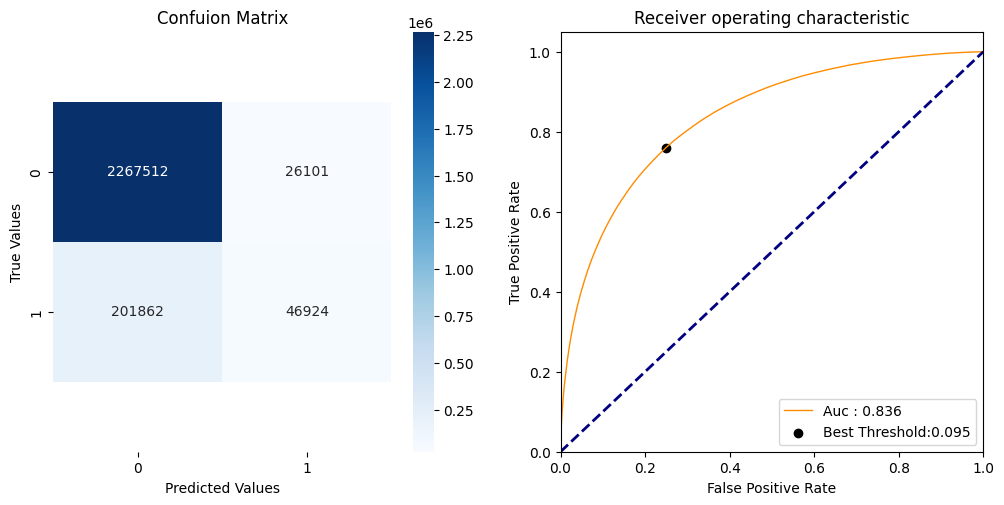

In [39]:
print ("\n Classification report : \n",classification_report(y_test, predictions))
print ("Accuracy   Score : ",accuracy_score(y_test, predictions))

#confusion matrix
conf_matrix = confusion_matrix(y_test,predictions)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

#f1-score
f1 = f1_score(y_test, predictions)
print("F1 Score: ", f1)

#roc_auc_score
model_roc_auc = roc_auc_score(y_test,probability) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probability)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix],3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()